In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

In [2]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        cross_entropy = K.binary_crossentropy(y_true, y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return loss

In [3]:
data_dir = 'D:/Datasets/Date & Orange Fruit'
img_height, img_width = 224, 224
batch_size = 32
epochs = 40

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Split data into training and validation
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3324 images belonging to 5 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1423 images belonging to 5 classes.


In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

In [13]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/40


C:\Users\Amr Samir\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.2488 - loss: 0.1457 - val_accuracy: 0.5151 - val_loss: 0.0499 - learning_rate: 1.0000e-05
Epoch 2/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.3951 - loss: 0.0890 - val_accuracy: 0.6381 - val_loss: 0.0370 - learning_rate: 1.0000e-05
Epoch 3/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.4863 - loss: 0.0689 - val_accuracy: 0.6880 - val_loss: 0.0316 - learning_rate: 1.0000e-05
Epoch 4/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.5479 - loss: 0.0573 - val_accuracy: 0.7442 - val_loss: 0.0275 - learning_rate: 1.0000e-05
Epoch 5/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.5872 - loss: 0.0498 - val_accuracy: 0.7576 - val_loss: 0.0249 - learning_rate: 1.0000e-05
Epoch 6/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.6312 - loss: 0.0441 - val_accuracy: 0.7674 - val_loss: 0.0229 - learning_rate: 1.0000e-05
Epoch 7/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.67

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 21,736,273 (82.92 MB)

 Trainable params: 7,217,541 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 14,435,084 (55.07 MB)

In [15]:
for layer in base_model.layers:
    layer.trainable = True

In [16]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

In [17]:
fine_tune_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 787s 7s/step - accuracy: 0.6298 - loss: 0.0487 - val_accuracy: 0.8173 - val_loss: 0.0174 - learning_rate: 1.0000e-06
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 738s 7s/step - accuracy: 0.6726 - loss: 0.0395 - val_accuracy: 0.8074 - val_loss: 0.0214 - learning_rate: 1.0000e-06
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 735s 7s/step - accuracy: 0.7177 - loss: 0.0316 - val_accuracy: 0.8236 - val_loss: 0.0179 - learning_rate: 1.0000e-06
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 736s 7s/step - accuracy: 0.7233 - loss: 0.0309 - val_accuracy: 0.8489 - val_loss: 0.0159 - learning_rate: 1.0000e-06
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 735s 7s/step - accuracy: 0.7607 - loss: 0.0257 - val_accuracy: 0.8658 - val_loss: 0.0136 - learning_rate: 1.0000e-06
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 735s 7s/step - accuracy: 0.7934 - loss: 0.0219 - val_accuracy: 0.8707 - val_loss: 0.0129 - learning_rate: 1.0000e-06
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - acc

In [18]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9480 - loss: 0.0078
Validation Loss: 0.0048
Validation Accuracy: 96.56%


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss =history.history['loss']
val_loss = history.history['val_loss']

<Figure size 640x480 with 0 Axes>

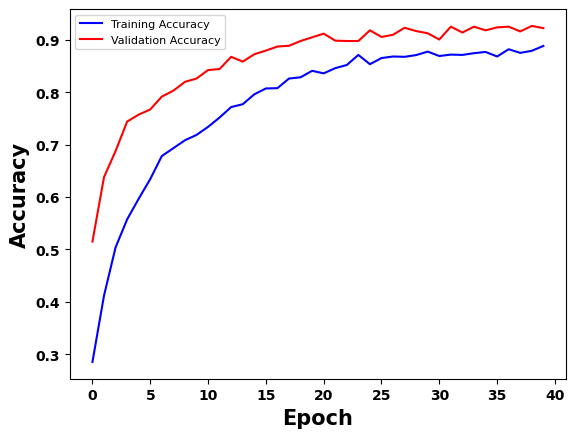

<Figure size 640x480 with 0 Axes>

In [25]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.xlabel("Epoch",fontsize= 15, fontweight='bold')
plt.ylabel("Accuracy",fontsize= 15, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(prop={'size': 8})
plt.figure()

<Figure size 640x480 with 0 Axes>

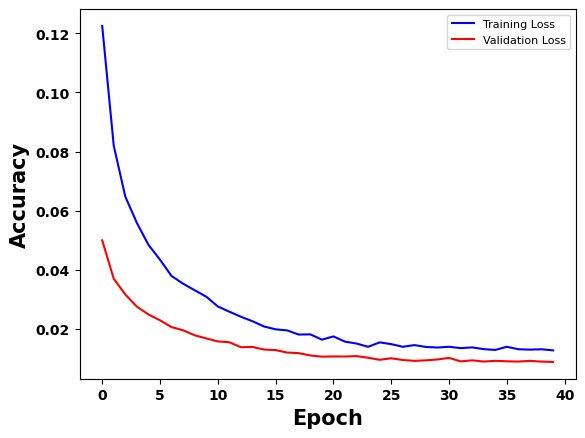

<Figure size 640x480 with 0 Axes>

In [26]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel("Epoch",fontsize= 15, fontweight='bold')
plt.ylabel("Accuracy",fontsize= 15, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(prop={'size': 8})
plt.figure()

In [19]:
Y_true = validation_generator.classes
Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step


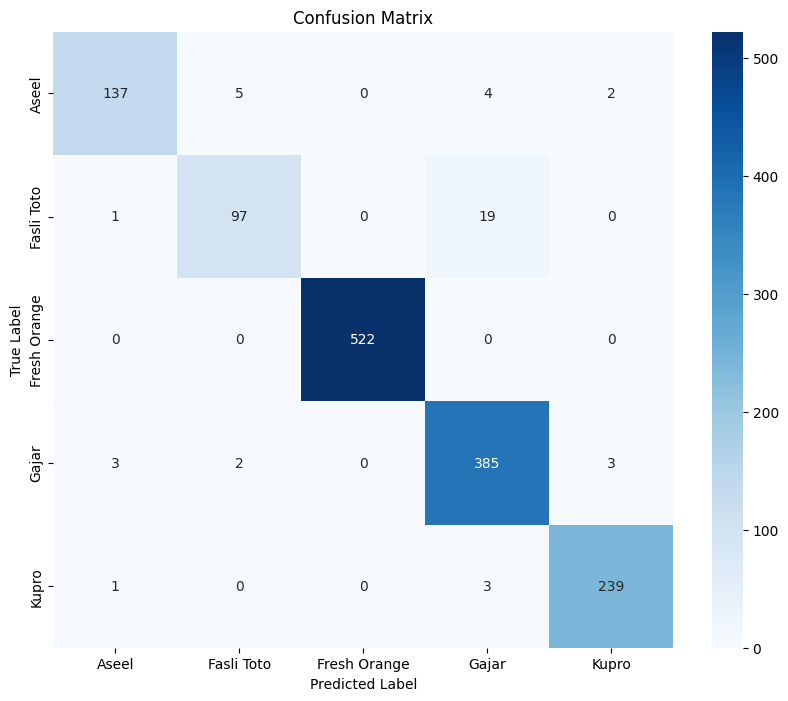

In [20]:
class_labels = list(validation_generator.class_indices.keys())
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       Aseel       0.96      0.93      0.94       148
  Fasli Toto       0.93      0.83      0.88       117
Fresh Orange       1.00      1.00      1.00       522
       Gajar       0.94      0.98      0.96       393
       Kupro       0.98      0.98      0.98       243

    accuracy                           0.97      1423
   macro avg       0.96      0.94      0.95      1423
weighted avg       0.97      0.97      0.97      1423



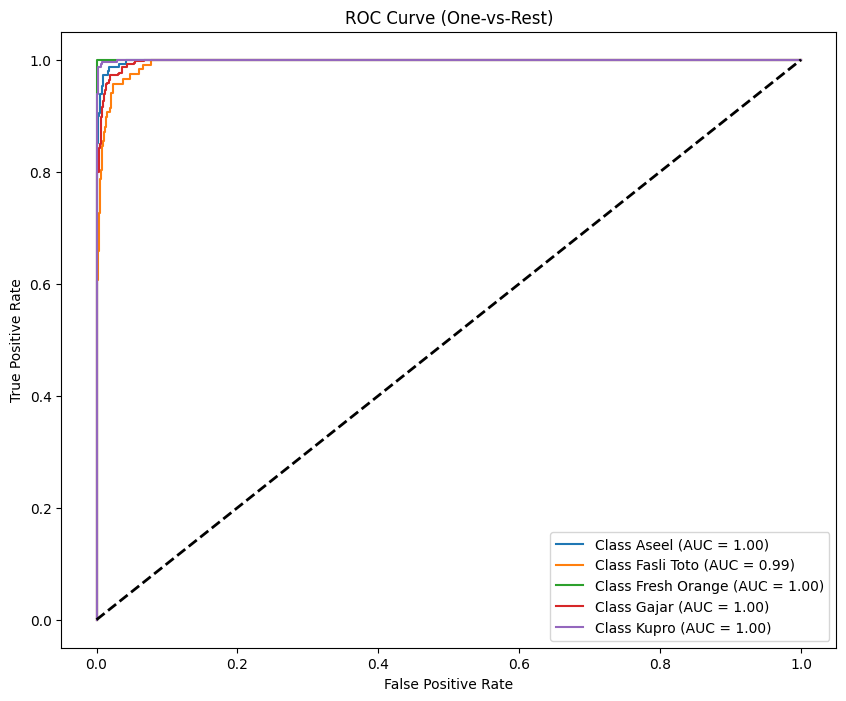

In [22]:
Y_true_binarized = label_binarize(Y_true, classes=np.arange(len(class_labels)))
fpr = {}
tpr = {}
roc_auc = {}
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [23]:
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, label in enumerate(class_labels):
    print(f"Accuracy for class {label}: {per_class_accuracy[i] * 100:.2f}%")

Accuracy for class Aseel: 92.57%
Accuracy for class Fasli Toto: 82.91%
Accuracy for class Fresh Orange: 100.00%
Accuracy for class Gajar: 97.96%
Accuracy for class Kupro: 98.35%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


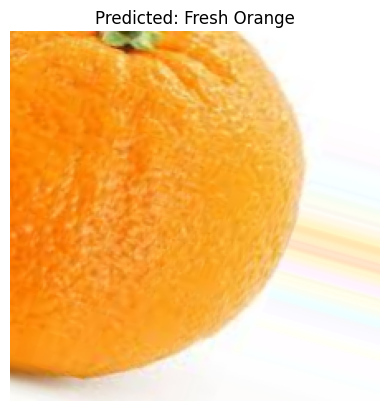

Predicted class: Fresh Orange
Confidence scores: [0.19220676 0.15309794 0.32017842 0.12047993 0.21403699]


In [28]:
from tensorflow.keras.preprocessing import image 

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_image_path = "C:/Users/Amr Samir/Desktop/download (1).jpg"

def preprocess_and_augment_image(image_path, img_height, img_width, datagen):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    augmented_images = datagen.flow(img_array, batch_size=1)
    augmented_img_array = next(augmented_images)[0]
    augmented_img_array = np.clip(augmented_img_array, 0, 255).astype('uint8')
    normalized_img_array = augmented_img_array / 255.0
    
    return augmented_img_array, normalized_img_array

img_height, img_width = 224, 224
augmented_img_array, normalized_img_array = preprocess_and_augment_image(
    test_image_path, img_height, img_width, train_datagen
)

predictions = model.predict(np.expand_dims(normalized_img_array, axis=0))
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = list(train_generator.class_indices.keys())[predicted_class_index]

plt.imshow(augmented_img_array)
plt.axis('off')
plt.title(f'Predicted: {predicted_class_label}')
plt.show()
print(f"Predicted class: {predicted_class_label}")
print(f"Confidence scores: {predictions[0]}")